# Max Cut problem with VQE

### Problem description

A graph is an object that contains nodes and connections between those nodes. Connections are weighted with specific values. The problem consists in dividing the nodes in two families, such that the divisory lines crosses as much weight as possible. So for example, given the following graph, you can try and guess the best cut:
![](maxcut1.png)

The solution is given by the following cut:
![](maxcut2.png)

We can use some physics for describing this problem. We can define some sort of cost function representing a given cut in order to minimize. This cost function is given by $E = \frac{1}{2}(w_s-w_d)$, where $w_s$ are the weight between same color nodes, and $w_d$ between diferent color nodes. Given $N$ nodes, we can think that each noche might be red or blue, or alternativly 0 or 1. This new notation might wake our intuition up: qubits. The same should happen with our cost function being called $E$: energy. So we can think of this problem as finding the minimum state of N qubits given a hamiltonian. For example, given 3 nodes with certain weight, we could have the following hamiltonian:
![](maxcut3.png)

This is the Max cut problem, which is known to be NP-Complete. A diferent cost function can be given centered on the nodes instead of the connections: $C = \sum_{ij} w_{ij}x_i(1-x_j)$, where $x_k$ might be 0 or 1 depending on the group at which the node belongs. An extension can be given by considering individual weights: $C = \sum_{ij} w_{ij}x_i(1-x_j) + \sum_i w_i x_i$. This problem might be mapped directly into an Ising Hamiltonian by consiering the transformation $x_i\rightarrow (I-Z_i)/2$: 

$H = \sum_i x_i Z_i + \sum_{ij}w_{ij}Z_iZ_j$

Now we can perform VQE with this Hamiltonian. For this example, our ansatz will be given by $|\psi(\theta)\rangle = [U_{single}(\theta)U_{entangler}]^M|+\rangle$, with $U_{single}(\theta) = \prod_i^N Y(\theta_i)$ (N is the number of qubits and M the circuit's depth). 
These problems can also be treated with annealing, but are limited to the connectivity of the device, which is a strong constraints in the genereal case. 

In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely


In [2]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to s

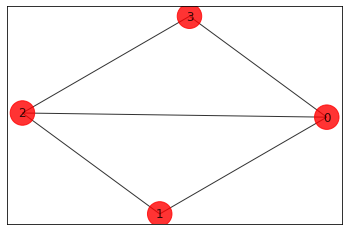

In [3]:
# Generating a graph of 4 nodes 

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Brute Force
Let's first tackle this problem via Brute force, i.e. by trying out all $2^N$ possible configuration. This is not a problem for $N=4$, but scales up pretty quickly.

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


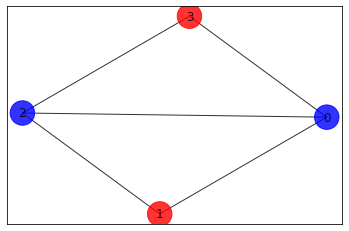

In [5]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))    

### Mapping to Ising


In [6]:
qubitOp, offset = max_cut.get_operator(w)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2020-07-18 12:24:11,036:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-1.5+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-1.5]),
    'energy': -1.5,
    'wavefunction': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}
2020-07-18 12:24:11,040:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)],

energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


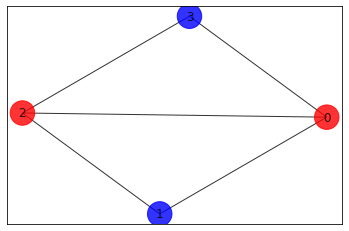

In [7]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

### Run on a Quantum Device
We will use BasicAer to simulate VQE on a quantum computer.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  after removing the cwd from sys.path.
2020-07-18 12:25:16,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f6c7be4e860>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:17,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.02111864] - 49.03364 (ms), eval count: 5
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:17,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.12426307] - 37.62412 (ms), eval count: 6
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:17,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.04283191] - 14.86373 (ms), eval count: 22
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:17,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.03666279] - 14.33778 (ms), eval count: 23
/home/marco/miniconda3/envs/tequila/lib/python3.7/sit

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:18,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.09759387] - 12.90989 (ms), eval count: 40
2020-07-18 12:25:18,043:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 20 of 25
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:18,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:18,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.64869883] - 17.13634 (ms), eval count: 56
2020-07-18 12:25:18,298:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: 0.7448763
2020-07-18 12:25:18,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: 0.6486988
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.ro

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:18,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.54690915] - 15.38873 (ms), eval count: 70
2020-07-18 12:25:18,692:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: -0.2637091
2020-07-18 12:25:18,693:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 9: -0.5469091
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:18,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.3351461] - 16.36767 (ms), eval count: 84
2020-07-18 12:25:18,950:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 16: -0.3096809
2020-07-18 12:25:18,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 16: -0.3351461
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scala

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:19,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.72115148] - 13.57579 (ms), eval count: 98
2020-07-18 12:25:19,214:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: -0.2986822
2020-07-18 12:25:19,215:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: -0.7211515
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scal

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:19,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.93774676] - 16.29925 (ms), eval count: 112
2020-07-18 12:25:19,475:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 30: -1.0148179
2020-07-18 12:25:19,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 30: -0.9377468
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:19,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.84148086] - 14.12392 (ms), eval count: 126
2020-07-18 12:25:19,718:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: -1.2239253
2020-07-18 12:25:19,719:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 37: -0.8414809
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:19,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.20722174] - 15.75875 (ms), eval count: 140
2020-07-18 12:25:19,971:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: -1.1488515
2020-07-18 12:25:19,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: -1.2072217
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:20,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.32565055] - 13.41939 (ms), eval count: 154
2020-07-18 12:25:20,210:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 51: -1.3825286
2020-07-18 12:25:20,211:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 51: -1.3256506
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:20,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.40551177] - 13.97920 (ms), eval count: 168
2020-07-18 12:25:20,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: -1.4032763
2020-07-18 12:25:20,458:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: -1.4055118
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:20,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.31021438] - 15.47241 (ms), eval count: 182
2020-07-18 12:25:20,710:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: -1.4448312
2020-07-18 12:25:20,712:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: -1.3102144
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:20,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.44168908] - 13.02314 (ms), eval count: 196
2020-07-18 12:25:20,944:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 72: -1.4411258
2020-07-18 12:25:20,945:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 72: -1.4416891
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:21,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47314808] - 19.41037 (ms), eval count: 210
2020-07-18 12:25:21,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: -1.4460902
2020-07-18 12:25:21,188:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 79: -1.4731481
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:21,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.458679] - 13.28349 (ms), eval count: 224
2020-07-18 12:25:21,465:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 86: -1.4850052
2020-07-18 12:25:21,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 86: -1.4586790
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scala

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:21,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.39744021] - 16.13235 (ms), eval count: 238
2020-07-18 12:25:21,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: -1.4342425
2020-07-18 12:25:21,702:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: -1.3974402
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:21,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46475586] - 13.33475 (ms), eval count: 252
2020-07-18 12:25:21,945:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: -1.4454884
2020-07-18 12:25:21,946:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: -1.4647559
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:22,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46439984] - 13.74698 (ms), eval count: 266
2020-07-18 12:25:22,173:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 107: -1.4732793
2020-07-18 12:25:22,174:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 107: -1.4643998
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:22,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47169738] - 14.77027 (ms), eval count: 280
2020-07-18 12:25:22,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: -1.4723223
2020-07-18 12:25:22,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: -1.4716974
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:22,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4841574] - 22.34411 (ms), eval count: 294
2020-07-18 12:25:22,649:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 121: -1.4834874
2020-07-18 12:25:22,650:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 121: -1.4841574
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:22,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45012878] - 15.26141 (ms), eval count: 308
2020-07-18 12:25:22,915:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: -1.4444870
2020-07-18 12:25:22,916:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: -1.4501288
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:23,157:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48458534] - 13.83877 (ms), eval count: 322
2020-07-18 12:25:23,158:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: -1.4890239
2020-07-18 12:25:23,158:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: -1.4845853
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:23,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46836519] - 13.22579 (ms), eval count: 336
2020-07-18 12:25:23,385:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: -1.4548021
2020-07-18 12:25:23,386:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 142: -1.4683652
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:23,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.44385627] - 16.33716 (ms), eval count: 350
2020-07-18 12:25:23,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: -1.4443734
2020-07-18 12:25:23,653:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: -1.4438563
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:23,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48449421] - 15.11073 (ms), eval count: 364
2020-07-18 12:25:23,957:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 156: -1.4801741
2020-07-18 12:25:23,958:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 156: -1.4844942
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:24,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46310705] - 13.16929 (ms), eval count: 378
2020-07-18 12:25:24,179:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: -1.4639643
2020-07-18 12:25:24,180:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: -1.4631071
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:24,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48535023] - 13.74340 (ms), eval count: 392
2020-07-18 12:25:24,409:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: -1.4861821
2020-07-18 12:25:24,411:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: -1.4853502
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:24,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4587701] - 18.69273 (ms), eval count: 406
2020-07-18 12:25:24,661:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: -1.4596230
2020-07-18 12:25:24,662:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: -1.4587701
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:24,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4861947] - 13.93008 (ms), eval count: 420
2020-07-18 12:25:24,913:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: -1.4894183
2020-07-18 12:25:24,914:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: -1.4861947
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:25,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46679754] - 13.89289 (ms), eval count: 434
2020-07-18 12:25:25,147:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 191: -1.4685180
2020-07-18 12:25:25,148:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 191: -1.4667975
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:25,396:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48126288] - 13.94176 (ms), eval count: 448
2020-07-18 12:25:25,397:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: -1.4849554
2020-07-18 12:25:25,398:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: -1.4812629
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:25,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48173817] - 12.90941 (ms), eval count: 462
2020-07-18 12:25:25,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 205: -1.4807286
2020-07-18 12:25:25,642:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 205: -1.4817382
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:25,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48608773] - 14.93526 (ms), eval count: 476
2020-07-18 12:25:25,894:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 212: -1.4858452
2020-07-18 12:25:25,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 212: -1.4860877
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:26,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48778856] - 16.38889 (ms), eval count: 490
2020-07-18 12:25:26,134:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 219: -1.4868635
2020-07-18 12:25:26,135:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 219: -1.4877886
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:26,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45439474] - 16.35766 (ms), eval count: 504
2020-07-18 12:25:26,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 226: -1.4542059
2020-07-18 12:25:26,369:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 226: -1.4543947
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:26,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4858916] - 13.13424 (ms), eval count: 518
2020-07-18 12:25:26,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 233: -1.4844280
2020-07-18 12:25:26,611:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 233: -1.4858916
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:26,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.49541152] - 15.08737 (ms), eval count: 532
2020-07-18 12:25:26,951:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: -1.4932563
2020-07-18 12:25:26,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: -1.4954115
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:27,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47944435] - 13.42320 (ms), eval count: 546
2020-07-18 12:25:27,181:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 247: -1.4802420
2020-07-18 12:25:27,182:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 247: -1.4794443
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:27,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48673965] - 14.17732 (ms), eval count: 560
2020-07-18 12:25:27,410:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 254: -1.4875432
2020-07-18 12:25:27,411:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 254: -1.4867396
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:27,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46985294] - 11.94310 (ms), eval count: 574
2020-07-18 12:25:27,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 261: -1.4654708
2020-07-18 12:25:27,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 261: -1.4698529
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:27,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45201847] - 15.45548 (ms), eval count: 588
2020-07-18 12:25:27,890:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 268: -1.4515946
2020-07-18 12:25:27,891:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 268: -1.4520185
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:28,117:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45568749] - 12.35700 (ms), eval count: 602
2020-07-18 12:25:28,118:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 275: -1.4568706
2020-07-18 12:25:28,118:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 275: -1.4556875
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:28,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46409522] - 14.05478 (ms), eval count: 616
2020-07-18 12:25:28,337:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 282: -1.4601098
2020-07-18 12:25:28,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 282: -1.4640952
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:28,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4541535] - 15.60855 (ms), eval count: 630
2020-07-18 12:25:28,572:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 289: -1.4555236
2020-07-18 12:25:28,573:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 289: -1.4541535
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:25:28,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47291034] - 12.36773 (ms), eval count: 644
2020-07-18 12:25:28,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 296: -1.4744214
2020-07-18 12:25:28,809:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 296: -1.4729103
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

energy: -1.49995781264974
time: 12.405842304229736
max-cut objective: -3.9999578126497397
solution: [1. 0. 1. 0.]
solution objective: 4.0


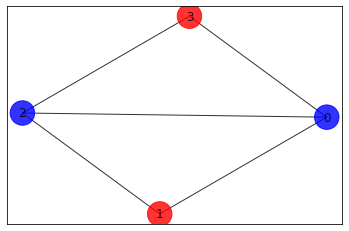

In [8]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  """
2020-07-18 12:28:55,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f6c7befdf28>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f6c7befdc88>>
-- initial_point: Ra

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:57,202:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: -0.3486328
2020-07-18 12:28:57,204:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: 0.1191406
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:28:57,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.21972656] - 36.86070 (ms), eval count: 61
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wil

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:57,772:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: -0.4072266
2020-07-18 12:28:57,772:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 9: -0.3935547
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:58,214:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 14: -0.5898438
2020-07-18 12:28:58,216:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 14: -0.6132812
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:58,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: -1.1455078
2020-07-18 12:28:58,619:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 19: -1.0605469
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:28:58,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.1640625] - 29.56772 (ms), eval count: 100
2020-07-18 12:28:58,967:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: -1.1708984
2020-07-18 12:28:58,967:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: -1.1640625
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.r

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:59,483:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 31: -1.2939453
2020-07-18 12:28:59,483:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: -1.2539062
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:28:59,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: -1.3212891
2020-07-18 12:28:59,822:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: -1.2998047
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:00,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.38769531] - 31.31127 (ms), eval count: 134
2020-07-18 12:29:00,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: -1.3320312
2020-07-18 12:29:00,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective fu

2020-07-18 12:29:00,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: -1.4111328
2020-07-18 12:29:00,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: -1.3828125
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:00,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: -1.4228516
2020-07-18 12:29:00,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: -1.4248047
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:00,941:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: -1.4755859
2020-07-18 12:29:00,942:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: -1.4238281
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:01,281:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: -1.4326172
2020-07-18 12:29:01,282:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: -1.4306641
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:01,614:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 63: -1.4804688
2020-07-18 12:29:01,614:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 63: -1.4521484
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:01,954:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 68: -1.4804688
2020-07-18 12:29:01,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 68: -1.4404297
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:02,347:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 73: -1.4667969
2020-07-18 12:29:02,348:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 73: -1.4550781
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:02,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.49023438] - 25.99835 (ms), eval count: 208
2020-07-18 12:29:02,690:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: -1.4667969
2020-07-18 12:29:02,692:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: -1.4902344
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:03,164:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 85: -1.4599609
2020-07-18 12:29:03,165:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 85: -1.4716797
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:03,496:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 90: -1.4921875
2020-07-18 12:29:03,497:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 90: -1.4902344
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:03,802:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: -1.4589844
2020-07-18 12:29:03,803:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: -1.4580078
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:04,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: -1.4863281
2020-07-18 12:29:04,118:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: -1.4814453
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:04,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: -1.4716797
2020-07-18 12:29:04,459:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: -1.4697266
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:04,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 110: -1.4667969
2020-07-18 12:29:04,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: -1.4843750
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:04,961:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:05,294:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: -1.4833984
2020-07-18 12:29:05,295:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: -1.4794922
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:05,640:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: -1.4599609
2020-07-18 12:29:05,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: -1.4599609
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:05,990:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 127: -1.4824219
2020-07-18 12:29:05,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 127: -1.4824219
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:06,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48828125] - 33.48446 (ms), eval count: 316
2020-07-18 12:29:06,312:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 132: -1.4921875
2020-07-18 12:29:06,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-18 12:29:06,443:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: -1.4931641
2020-07-18 12:29:06,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: -1.4892578
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:06,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 139: -1.4960938
2020-07-18 12:29:06,852:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 139: -1.4970703
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:07,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48242188] - 29.45328 (ms), eval count: 340
2020-07-18 12:29:07,151:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 144: -1.4843750
2020-07-18 12:29:07,152:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-18 12:29:07,277:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: -1.4677734
2020-07-18 12:29:07,278:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: -1.4746094
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:07,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.484375] - 31.71229 (ms), eval count: 349
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:07,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 153: -1.4746094
2020-07-18 12:29:07,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 153: -1.4667969
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:08,022:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: -1.4746094
2020-07-18 12:29:08,022:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: -1.4687500
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:08,329:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: -1.4560547
2020-07-18 12:29:08,330:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: -1.4638672
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:08,656:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 168: -1.4902344
2020-07-18 12:29:08,657:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 168: -1.4833984
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:08,961:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 173: -1.4482422
2020-07-18 12:29:08,962:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 173: -1.4697266
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:09,106:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:09,382:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 180: -1.4863281
2020-07-18 12:29:09,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: -1.4785156
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:09,682:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 185: -1.4912109
2020-07-18 12:29:09,683:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 185: -1.4824219
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:09,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48632812] - 27.56357 (ms), eval count: 432
2020-07-18 12:29:09,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 190: -1.4853516
2020-07-18 12:29:09,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-18 12:29:10,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: -1.4892578
2020-07-18 12:29:10,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: -1.4843750
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:10,239:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46875] - 28.91898 (ms), eval count: 441
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will 

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:10,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 199: -1.4951172
2020-07-18 12:29:10,514:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 199: -1.4882812
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:10,819:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 204: -1.4863281
2020-07-18 12:29:10,819:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 204: -1.4902344
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:10,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47753906] - 32.46021 (ms), eval count: 465
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wi

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:11,244:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 211: -1.4628906
2020-07-18 12:29:11,245:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 211: -1.4687500
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:11,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.49121094] - 28.62287 (ms), eval count: 484
2020-07-18 12:29:11,571:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 216: -1.4882812
2020-07-18 12:29:11,571:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 216: -1.4912109
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scala

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:11,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4921875] - 25.60806 (ms), eval count: 498
2020-07-18 12:29:11,976:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 223: -1.4980469
2020-07-18 12:29:11,977:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective fu

2020-07-18 12:29:12,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 225: -1.4863281
2020-07-18 12:29:12,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 225: -1.4921875
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:12,380:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 230: -1.4970703
2020-07-18 12:29:12,381:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 230: -1.5000000
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:12,681:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 235: -1.4931641
2020-07-18 12:29:12,682:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 235: -1.4951172
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:12,981:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: -1.4863281
2020-07-18 12:29:12,982:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: -1.4970703
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:13,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47070312] - 26.12066 (ms), eval count: 537
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wi

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:13,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48535156] - 29.12402 (ms), eval count: 546
2020-07-18 12:29:13,415:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 247: -1.4853516
2020-07-18 12:29:13,416:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 247: -1.4853516
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scala

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:13,862:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 254: -1.4677734
2020-07-18 12:29:13,863:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 254: -1.4736328
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:14,143:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 259: -1.4726562
2020-07-18 12:29:14,144:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 259: -1.4794922
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-18 12:29:14,291:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:14,589:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 266: -1.4853516
2020-07-18 12:29:14,591:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 266: -1.4814453
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:14,919:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 271: -1.4804688
2020-07-18 12:29:14,920:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 271: -1.4765625
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:15,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 276: -1.4765625
2020-07-18 12:29:15,232:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 276: -1.4794922
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:15,538:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 281: -1.4941406
2020-07-18 12:29:15,538:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 281: -1.4980469
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:15,838:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 286: -1.4453125
2020-07-18 12:29:15,839:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 286: -1.4550781
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:16,123:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 291: -1.4960938
2020-07-18 12:29:16,124:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 291: -1.4921875
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-18 12:29:16,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 296: -1.4755859
2020-07-18 12:29:16,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 296: -1.4716797
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

energy: -1.5
time: 21.63572335243225
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


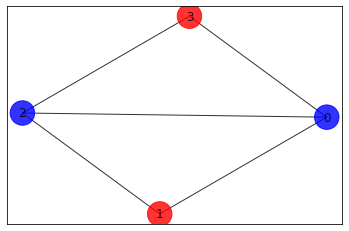

In [9]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)